**Description**: Why did precision drop in production? This notebook proves that an
arbitrary out-of-sample precision can be achieved simply by reducing the frequency of
positive observations going from in-sample to out-of-sample data. The analysis reveals a
simple workflow which detects and remedies a drop in precision for anticausal learning
problems:

1. To identify the problem, track the average production prediction (as a proxy for the
   average production label). If there's evidence that this decreased, then estimate the
   precision in production by labeling ≥200 observations which were predicted to be
   positive. Expect this estimate of precision to be lower than the one you computed on
   in-sample data.
2. Estimate the new proportion of positives in production using
   `estimate_frac_positives_out_sample` (or by counting if you've labeled negative
   observations as well).
3. To fix the problem, a simple temporary fix is to adjust predictions using the ratio
   of proportions of positives in production vs. in-sample. This fix is implemented in
   `predict_proba_adjusted`.

**Estimated runtime**: 5 sec.

**Required packages**:
```
matplotlib>=3.4.3
scikit-learn>=0.24.2
```

[Input desired precision](#input-desired-precision)

[Prepare in-sample data](#prepare-in-sample-data)

[Fit](#fit)

[Gather in-sample metrics](#gather-in-sample-metrics)

[Specify out-of-sample distribution](#specify-out-of-sample-distribution)

[Gather out-of-sample metrics](#gather-out-of-sample-metrics)

[A simple fix](#a-simple-fix)

[A note on covariate drift detectors](#a-note-on-covariate-drift-detectors)

  * [References](#references)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Input desired precision

By default, in-sample precision is ~0.95. The desired precision should be less than
that, since the notebook drops positives. If we want greater precision, we'd have to
drop negatives.

In [2]:
desired_precision_out_sample = 0.60
assert desired_precision_out_sample < 0.95

Hypothesis: assuming a model is calibrated-in-the-large, then precision decreases
but recall stays the same on data which has fewer positives.

# Prepare in-sample data

In [3]:
X, y = make_classification(
    n_samples=100_000,
    n_classes=2,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    random_state=123,  # this seed gets ~95% precision. dont change it lol
)

Split this data into in-sample data—the sample we used to train and test a model—and
out-of-sample data, i.e., data after the model is deployed. The only difference between
in-sample and out-of-sample data is the frequency of positive observations. (A "positive
observation" is an observation whose label is 1.)

In [4]:
# split into in and out-of-sample data. we'll make out-of-sample data unbalanced
_X_in_sample, _X_out_sample, _y_in_sample, _y_out_sample = train_test_split(
    X, y, test_size=0.2, random_state=120741
)

# split in-sample data into training and test. both balanced
X_tr, X_te, y_tr, y_te = train_test_split(
    _X_in_sample, _y_in_sample, test_size=0.2, random_state=81545
)

In [5]:
# in-sample data is balanced
print(y_tr.mean())
print(y_te.mean())

0.498921875
0.5015


# Fit

We'll fit a logistic regression b/c we know it's calibrated-in-the-large.

In [6]:
model = LogisticRegression().fit(X_tr, y_tr)
_accuracy = model.score(X_tr, y_tr)
assert _accuracy > 0.94, f"accuracy: {round(_accuracy, 3)}. That's not good enough!"

# Gather in-sample metrics

In [7]:
def metrics(y_true: np.ndarray, y_pred: np.ndarray):
    """
    - Fraction `y_true` positive
    - Fraction `y_pred` positive
    - Precision
    - Recall
    - Specificity
    """
    # input checks
    _binary_array = np.array([0, 1])
    if not np.all(np.unique(y_true) == _binary_array):
        raise ValueError("y_true must only contain 0s and 1s.")
    if not np.all(np.unique(y_pred) == _binary_array):
        raise ValueError("y_pred must only contain 0s and 1s.")

    metric_to_value = dict()
    # marginal scores
    metric_to_value["frac_positive"] = y_true.sum() / len(y_true)
    metric_to_value["frac_positive_pred"] = y_pred.sum() / len(y_pred)
    # conditional scores
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metric_to_value["precision"] = tp / (tp + fp)
    metric_to_value["recall"] = tp / (tp + fn)
    metric_to_value["specificity"] = tn / (tn + fp)

    return metric_to_value

In [8]:
metrics_in_sample = metrics(y_te, model.predict(X_te))

In [9]:
metrics_in_sample

{'frac_positive': 0.5015,
 'frac_positive_pred': 0.5005,
 'precision': 0.9441808191808192,
 'recall': 0.9422981056829511,
 'specificity': 0.9439568706118355}

Model looks great on in-sample data. Deploy it! ([no](https://youtu.be/m_-qJKKz_Go?t=5))

# Specify out-of-sample distribution

In this section, we'll formalize some stuff so that we can figure out how to achieve
`desired_precision_out_sample`.

Let $P$ be the distribution from which our in-sample data was sampled, and $Q$ be that
for out-of-sample / production data. The only fundamental difference between the
universes of $P$ and $Q$ is that the latter has fewer positive observations.

Assume a model was fit on a sample from $P$. Assume the model is
calibrated-in-the-large, i.e., $P(Y = 1) = P(\hat{Y} = 1)$. We need a way to calculate
$q = Q(Y = 1)$ so that it results in a given precision on $Q$. Recall and specificity
are equivalent across $P$ and $Q$, because these metrics are conditional on the class,
which was the only thing that changed. (This fact is demonstrated later.)

Apply Bayes' rule to the precision on $Q$:

$$
\begin{align*}
Q(Y = 1 \: | \: \hat{Y} = 1) &= Q(\hat{Y} = 1 \: | \: Y = 1) \frac{Q(Y = 1)}{ Q(\hat{Y}
= 1)} \\
Q(Y = 1 \: | \: \hat{Y} = 1) &= P(\hat{Y} = 1 \: | \: Y = 1) \frac{Q(Y = 1)}{Q(\hat{Y} =
1)}
\end{align*}
$$

At this point, we can already see the problem. A drop from in-sample precision occurs
when $Q(Y = 1) < Q(Ŷ = 1)$. This happens if our in-sample data over-sampled the positive
class, because our trained model ends up overestimating the frequency of positive
observations.

Back to the main calculation:

$$
\begin{align*}
Q(Y = 1) &= \frac{Q(Y = 1 \: | \: \hat{Y} = 1)}{P(\hat{Y} = 1 \: | \: Y = 1)} Q(\hat{Y}
= 1) \\
q &= \frac{Q_{\text{precision}}}{P_{\text{recall}}} Q(\hat{Y} = 1) \\
&= r Q(\hat{Y} = 1).
\end{align*}
$$

If we were just trying to estimate $q$ given in-sample and out-of-sample metrics, then
we'd be done here. But for this analysis, we're trying to set $q$ based only on
out-of-sample precision and whatever in-sample metrics. We can't estimate $Q(\hat{Y} =
1)$ because we haven't even specified what $Q$ is! We have to go a bit further to get
around this chicken-egg problem. Apply the law of total probability to break down
$Q(\hat{Y} = 1)$:

$$
\begin{align*}
Q(\hat{Y} = 1) &= Q(\hat{Y} = 1 \: | \: Y = 1)q + Q(\hat{Y} = 1 \: | \: Y = 0)(1-q) \\
&= P(\hat{Y} = 1 \: | \: Y = 1)q + P(\hat{Y} = 1 \: | \: Y = 0)(1-q) \\
&= P_{\text{recall}}q + (1 - P_{\text{specificity}})(1-q).
\end{align*}
$$

Plugging it in to the first equation for $q$, we can now solve for $q$:

$$
\begin{align*}
q &= r \cdot \big( P_{\text{recall}}q + (1 - P_{\text{specificity}})(1-q) \big) \\
q &= r \cdot \big( P_{\text{recall}}q + (1 - P_{\text{specificity}}) - (1 -
P_{\text{specificity}})q \big) \\
q - r P_{\text{recall}}q + r(1 - P_{\text{specificity}})q &= r \cdot \big( 1 -
P_{\text{specificity}} \big) \\
q &= \frac{r \cdot \big( 1 - P_{\text{specificity}} \big)}{1 - r P_{\text{recall}} + r
\cdot \big( 1 - P_{\text{specificity}} \big)}
\end{align*}
$$

So we can calculate the fraction of positives in $Q$ given in-sample recall, in-sample
precision, and out-of-sample precision (it's the numerator of the ratio $r$).

In [10]:
def estimate_frac_positives_out_sample(
    out_sample_precision: float,
    in_sample_recall: float,
    in_sample_specificity: float = None,
    out_sample_frac_positive_pred: float = None,
) -> float:
    """
    Estimates the fraction of positive observations in out-of-sample data given:
    - out-of-sample precision
    - in-sample recall
    - either in-sample specificity, or the fraction of out-of-sample predictions which
    are positive. Supplying the latter should result in more accurate estimation.

    Parameters
    ----------
    out_sample_precision : float
        out-of-sample precision
    in_sample_recall : float
        in-sample recall
    in_sample_specificity : float, optional
        in-sample specificity, by default None
    out_sample_frac_positive_pred : float, optional
        out-of-sample fraction of positive predictions, by default None

    Returns
    -------
    float
        Estimated fraction of positive observations in out-of-sample data.

    Raises
    ------
    ValueError
        if neither `in_sample_specificity` nor `out_sample_frac_positive_pred` are
        provided.
    """
    if out_sample_frac_positive_pred is None and in_sample_specificity is None:
        raise ValueError(
            "in_sample_specificity or out_sample_frac_positive_pred must be specified. "
            "The latter should result in more accurate estimation."
        )
    if out_sample_frac_positive_pred is not None:
        return (out_sample_precision / in_sample_recall) * out_sample_frac_positive_pred
    _r = out_sample_precision / in_sample_recall
    _numerator = _r * (1 - in_sample_specificity)
    return _numerator / (1 - _r * in_sample_recall + _numerator)

In [11]:
_q = estimate_frac_positives_out_sample(
    desired_precision_out_sample,
    metrics_in_sample["recall"],
    in_sample_specificity=metrics_in_sample["specificity"],
)

# calculate the drop_probability needed to achieve q
_n_pos = _y_out_sample.sum()
_n_neg = len(_y_out_sample) - _n_pos
drop_probability = 1 - ((_q * _n_neg) / (_n_pos - _q * _n_pos))
drop_probability

0.9116045763839605

In [12]:
# make out-of-sample data unbalanced, dropping positives

rng = np.random.default_rng(seed=abs(hash("🦖 ☄️ 💥")))  # Happy Asteroid Day!

mask_positive = _y_out_sample == 1
mask = ~mask_positive
mask_random = rng.choice(
    [True, False], size=mask_positive.sum(), p=[1 - drop_probability, drop_probability]
)
mask[mask_positive] = mask_random

# no negative labels dropped
assert (_y_out_sample[mask] == 0).sum() == (_y_out_sample == 0).sum()

# some positive labels dropped
assert _y_out_sample[mask].sum() < _y_out_sample.sum()

# apply mask to simulate out-of-sample data, which isn't balanced
X_out_sample = _X_out_sample[mask]
y_out_sample = _y_out_sample[mask]

# Gather out-of-sample metrics

First, recall in-sample metrics:

In [13]:
metrics_in_sample

{'frac_positive': 0.5015,
 'frac_positive_pred': 0.5005,
 'precision': 0.9441808191808192,
 'recall': 0.9422981056829511,
 'specificity': 0.9439568706118355}

Here are out-of-sample metrics:

In [14]:
metrics_out_sample = metrics(y_out_sample, model.predict(X_out_sample))
metrics_out_sample

{'frac_positive': 0.08367854183927093,
 'frac_positive_pred': 0.12703673018503175,
 'precision': 0.6253623188405797,
 'recall': 0.9493949394939494,
 'specificity': 0.9480610809724733}

Quite close to the desired 60% precision. The sources of error are that we used
in-sample recall to estimate out-of-sample recall and specificity. Recall stayed
similar.

Methinks it's close enough. Hypothesis confirmed.

# A simple fix

The simplest fix for pure classification tasks is to re-tune the threshold. But in many
applications, you need probabilities. How do we fix them?

Let's recall the story. You've deployed a model trained on $P$, only to see that its
precision (but not recall) has dropped on $Q$. The basic analysis above revealed to you
that the drop is likely explained by a reduced frequency of positives in $Q$.

If you recall Bayes' rule, you know that the class frequency is just a number which gets
multiplied by the likelihood. Crucially, the likelihood is fixed from $P$ to $Q$. Maybe
we can figure out how to transform probabilities on $P$ to probabilities on $Q$ by
changing the quantity that gets multiplied.

Probabilities from in-sample data (where we trained) are:

$$
\begin{align*}
y_P &= P(Y = 1 \: | \: x) \\
&= \frac{P(x \: | \: Y = 1) p}{P(x)} \\
&= \frac{P(x \: | \: Y = 1) p}{P(x \: | \: Y = 1) p + P(x \: | \: Y = 0) (1-p)}
\end{align*}
$$

On out-of-sample data, they should be:

$$
\begin{align*}
y_Q &= Q(Y = 1 \: | \: x) \\
&= \frac{Q(x \: | \: Y = 1) q}{Q(x \: | \: Y = 1) q + Q(x \: | \: Y = 0) (1-q)} \\
&= \frac{P(x \: | \: Y = 1) q}{P(x \: | \: Y = 1) q + P(x \: | \: Y = 0) (1-q)}
\end{align*}
$$

Using the facts that

$$
\begin{align*}
P(x \: | \: Y = 1) &= \frac{P(Y = 1 \: | \: x) P(x)}{p} \\
&= P(x) \frac{y_P}{p}
\end{align*}
$$

and

$$
\begin{align*}
P(x \: | \: Y = 0) &= \frac{P(Y = 0 \: | \: x) P(x)}{1 - p} \\
&= P(x) \frac{1 - y_P}{1 - p}
\end{align*}
$$

we can express $y_Q$ purely as a function of $y_P, p, q$:

$$
\begin{align*}
y_Q &= \frac{P(x) \frac{y_P}{p} q}{P(x) \frac{y_P}{p} q + P(x) \frac{1-y_P}{1-p}(1-q)}
\\
&= \frac{P(x) y_P \cdot \frac{q}{p}}{P(x) \bigg( y_P \cdot \frac{q}{p} + (1 - y_P) \cdot
\frac{1-q}{1-p} \bigg)} \\
&= \frac{y_P \cdot \frac{q}{p}}{y_P \cdot \frac{q}{p} + (1 - y_P) \cdot
\frac{1-q}{1-p}}
\end{align*}
$$

In other words, if the only difference b/t $P$ and $Q$ is the frequency of positives, we
can "re-calibrate" Bayes-optimal probabilities from $P$ so that they're Bayes-optimal
for $Q$. For this to work of course, $\hat{y}_P$ should be well-calibrated.

(The adjustment rule can be extended to multi-class problems.)

Let's empirically evaluate the adjustment rule, plugging in estimates for true values.

In [15]:
(X_out_sample_tr, X_out_sample_te, y_out_sample_tr, y_out_sample_te) = train_test_split(
    X_out_sample,
    y_out_sample,
    test_size=0.5,
    random_state=257452145,
)

In [16]:
def predict_proba_adjusted(
    pred_probs_out_sample: np.ndarray,
    frac_positive_out_sample_est: float,
    frac_positive_in_sample_est: float,
) -> np.ndarray:
    """
    Adjusts predictions made by a model trained on a sample whose class frequency is
    different than that of out-of-sample / production data.

    Parameters
    ----------
    pred_probs_out_sample : np.ndarray
        1-D array of predicted probabilities of the positive class. These are assumed
        to come from a model trained on biased in-sample data which has been applied to
        out-of-sample data
    frac_positive_out_sample_est : float
        estimated fraction of positives in out-of-sample data
    frac_positive_in_sample_est : float
        estimated fraction of positives in in-sample data

    Returns
    -------
    np.ndarray
        1-D array of adjusted predicted probabilities of the positive class
    """
    _numerator = pred_probs_out_sample * (
        frac_positive_out_sample_est / frac_positive_in_sample_est
    )
    _denominator = _numerator + (
        (1 - pred_probs_out_sample)
        * ((1 - frac_positive_out_sample_est) / (1 - frac_positive_in_sample_est))
    )
    return _numerator / _denominator

We need to estimate $q$, i.e., `frac_positive_out_sample_est`, the fraction of positives
in out-of-sample data.

Here's a nice fact. Say we computed out-of-sample precision by *only labeling positive
predictions (from production)* for correctness, i.e., we never looked at negative
predictions. We can still estimate the fraction of positives in out-of-sample data by
using the formula in `estimate_frac_positives_out_sample`.

In [17]:
preds_out_sample_tr = model.predict(X_out_sample_tr)

out_sample_precision_est = precision_score(
    y_out_sample_tr, preds_out_sample_tr
)

frac_positive_out_sample_est = estimate_frac_positives_out_sample(
    out_sample_precision_est,
    metrics_in_sample["recall"],
    out_sample_frac_positive_pred=preds_out_sample_tr.sum() / len(preds_out_sample_tr),
)

Apply the adjustment.

In [18]:
pred_probs_out_sample_te = model.predict_proba(X_out_sample_te)[:, 1]

pred_probs_out_sample_te_adjusted = predict_proba_adjusted(
    pred_probs_out_sample_te,
    frac_positive_out_sample_est,
    metrics_in_sample["frac_positive"],
)

How good are the adjusted predictions? We'll use a calibration curve to evaluate.

In [19]:
def plot_calibration_curve(y, pred_probs, n_bins=5, title=""):
    # gather statistics
    prob_true, prob_pred = calibration_curve(y, pred_probs, n_bins=n_bins)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_inds = np.digitize(pred_probs, bins) - 1
    bin_sizes = np.bincount(bin_inds)
    y_std_err = np.sqrt(prob_true * (1 - prob_true) / bin_sizes)

    # plot curve
    plt.errorbar(
        prob_pred,
        prob_true,
        yerr=2 * y_std_err,
        label="Model w/ 95% CI",
        capsize=5,
        marker="o",
        linestyle="dashed",
    )
    plt.plot([0, 1], [0, 1], label="Perfect calibration")
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction")
    plt.title(title)

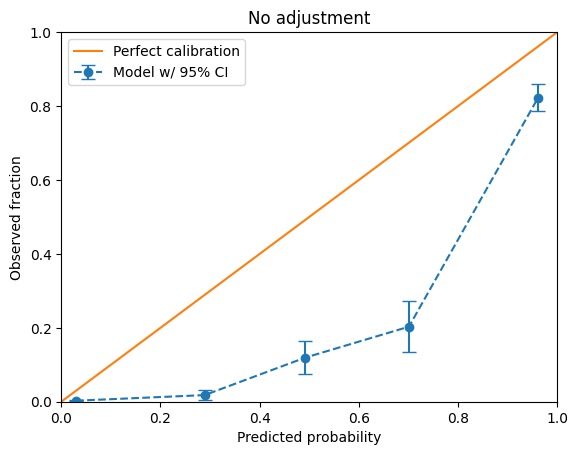

In [22]:
plot_calibration_curve(
    y_out_sample_te, pred_probs_out_sample_te, title="No adjustment"
)

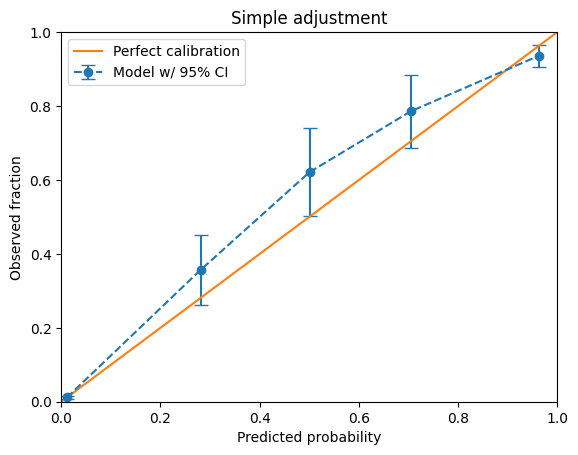

In [20]:
plot_calibration_curve(
    y_out_sample_te, pred_probs_out_sample_te_adjusted, title="Simple adjustment"
)

The adjustment is an underestimator presumably because the ratio $q/p$ is
underestimated. I should look into why this is systematic.

If we had a labeled dataset which includes positives and negatives, we could instead fit
a logistic regression on top of the original model's predicted probabilities. Let's see
how that compares.

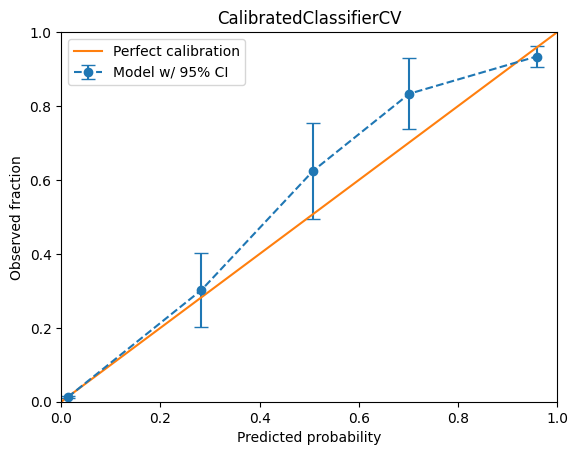

In [21]:
recalibrator = CalibratedClassifierCV(estimator=model).fit(
    X_out_sample_tr, y_out_sample_tr
)
plot_calibration_curve(
    y_out_sample_te,
    recalibrator.predict_proba(X_out_sample_te)[:, 1],
    title="CalibratedClassifierCV",
)

After running the notebook on many different seeds, there isn't a case where
`CalibratedClassifierCV` is significantly better than the adjustment rule. Recall that
the adjustment rule only requires out-of-sample positive predictions to be labeled for
correctness.

# A note on covariate drift detectors

The top of this notebook says that this analysis "reveals a simple workflow which
detects and remedies a drop in precision for anticausal learning problems".

What's an "anticausal learning problem", and why did I need to specify that? An
anticausal learning problem is one where the target causes covariates.<sup>1</sup> For
example, diseases cause symptoms. In these problems, $P(x \: | \: y)$ is fixed. This
means that the only thing we need to track and correct is the marginal probability
distribution over labels. Tracking the distribution of covariates is useless. Why?
Because, in this setting, covariate shift is completely explained by label shift:

$$
\begin{align*}
Q(x) &= \sum_{y} Q(x \: | \: y) Q(y) && \text{total probability} \\
&= \sum_{y} P(x \: | \: y) Q(y)      && \text{anticausal} \\
&\neq  \sum_{y} P(x \: | \: y) P(y)  && \text{label shift} \\
&= P(x)
\end{align*}
$$

For a common class of learning tasks, covariate shift alerts are actually a red herring.
The problem was just label shift, for which there are simple remedies which don't
involve retraining. These remedies include the adjustment rule above, and the method in
[this paper](http://proceedings.mlr.press/v80/lipton18a/lipton18a.pdf)<sup>2</sup>.

Note that this fact has nothing to do with the accuracy of covariate shift detectors,
which are theoretically and empirically
[faulty](https://www.nannyml.com/blog/when-data-drift-does-not-affect-performance-machine-learning-models).

I wanted to mention this because you may not need any data to decide beforehand whether
to set up covariate drift alerts; you just need some domain understanding. If you know
that your task is an anticausal one, then covariate drift alerts are definitely not
worth implementing over simple prediction averaging. On the other hand, if you know your
task is a causal one (e.g., house features cause its price) then covariate drift
estimators may be diagnostically useful.

These aren't my ideas btw. They're pulled straight out of [this lesser-known talk which
covers the two most popular types of ML engineering
workflows](https://www.youtube.com/watch?v=enBoCZnSsvw).

## References

1. Schölkopf, Bernhard, et al. "On causal and anticausal learning." arXiv preprint
   arXiv:1206.6471 (2012).
2. Lipton, Zachary, Yu-Xiang Wang, and Alexander Smola. "Detecting and correcting for
   label shift with black box predictors." International conference on machine learning.
   PMLR, 2018.